In [ ]:
#Studnet: Jhuma kabir meem
#Exercise Bayes' theorem liklyhood

In [1]:
# -- initialize the device
# !pip install pycuda
import numpy as np
import math
from timeit import default_timer as timer  
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels import api
from scipy import stats
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
import time

In [58]:
###### CPU imlementation of Bayes' theorem Likelihood, This part is not important for the project. Just I wanted to check if GPU output is same as CPU ######
# generate an independent variable 
x = np.linspace(-10, 30, 100)
# generate a normally distributed residual
noise = np.random.normal(10, 5, 100)
theta1=10
theta2= 4
# generate ground truth equation
y = theta1 + theta2*x + noise

df = pd.DataFrame({'x':x, 'y':y})
df.head() 

features = api.add_constant(df.x)
model = api.OLS(y, features).fit()
model.summary() 
res = model.resid
standard_dev = np.std(res)*1.8

# MLE function
# ml modeling and neg LL calculation
def MLE_Norm(parameters):
  # extract parameters
  const, beta, std_dev = parameters
  # predict the output
  pred = const + beta*x
  # Calculate the log-likelihood for normal distribution
  LL = np.sum(stats.norm.logpdf(y, pred, std_dev))
  # Calculate the negative log-likelihood
  neg_LL = -1*LL
  return neg_LL 
mle_model = minimize(MLE_Norm, np.array([2,2,2]), method='L-BFGS-B')

print('Out put from Ground truth equation:', y)
print('Standard deviation:', standard_dev)
print('Mean:', np.mean(y))

Out put from Ground truth equation: [-17.48733549  -9.96284891 -16.78636499 -10.95438706 -11.45048488
 -15.83256118 -11.1054062   -7.1971344   -7.85707048  -9.59048964
   3.94648158   4.31168754  -1.42077335  -5.30801345   2.19588031
   5.31240715   6.12283111  16.65689251   9.84452564   3.33533562
   2.2434895   23.78052456  12.29418366  19.70860623  13.83354513
  20.33017336  24.38321929  31.48610275  26.73588138  24.55815249
  25.57275276  26.52291323  37.72542754  30.40094394  32.06289719
  39.28710171  43.8302664   40.60929472  37.43646565  48.39596211
  51.75278923  40.11224715  49.73450169  50.03990008  45.42654697
  52.66258054  43.2847179   50.13495832  48.1305708   53.30499223
  69.99535905  68.29183399  53.4769135   57.15517579  62.00541813
  71.28864783  67.44212888  73.53455059  80.9831719   77.34387984
  77.06680715  78.08882907  77.30239666  83.27027373  85.06440987
  77.21997982  85.04105577  85.25404948  91.52022739  97.15973372
  95.77469686 109.91715701  97.83953599 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Out put from Ground truth equation using GPU: [-17.487335   -9.962849  -16.786366  -10.954388  -11.450486  -15.832561
 -11.105406   -7.197134   -7.857071   -9.59049     3.9464817   4.3116875
  -1.4207726  -5.308013    2.19588     5.3124065   6.1228313  16.65689
   9.844525    3.3353353   2.2434893  23.780525   12.294184   19.708607
  13.833546   20.330173   24.383219   31.486103   26.735882   24.558151
  25.572752   26.522913   37.725426   30.400944   32.062897   39.2871
  43.830265   40.609295   37.436466   48.39596    51.752792   40.112247
  49.7345     50.0399     45.426548   52.66258    43.284718   50.134956
  48.13057    53.30499    69.99536    68.29184    53.476913   57.155178
  62.005417   71.28865    67.44213    73.53455    80.98317    77.34387
  77.0668     78.08883    77.3024     83.27027    85.06441    77.21998
  85.04105    85.25405    91.520226   97.15974    95.7747    109.91716
  97.83954    91.28392   106.49259   104.1507     99.902374  101.54692
 105.38159   105.1472   

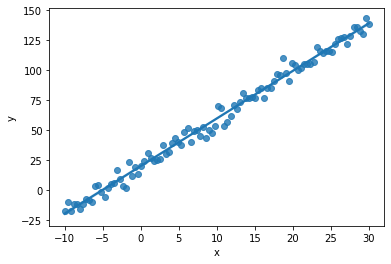

In [66]:
# Test bayes therorem with python GPU, This is the main part  here I have used all karnel from the template 

#GPU lirabires 
import pycuda.driver as cuda
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
from pycuda import driver, compiler, gpuarray, tools
from pycuda.compiler import SourceModule

# generate an independent variable 
xn = np.linspace(-10, 30, 100).astype(np.float32)
x_s= gpuarray.to_gpu(x.astype(np.float32))
# generate a normally distributed residual
e = np.random.normal(10, 5, 100).astype(np.float32)
noise = gpuarray.to_gpu(noise.astype(np.float32))
theta1=10
theta2= 4

size=len(x) #size of N

XS = np.array(y).astype(np.float32) # delcare array 
a = gpuarray.to_gpu(XS)

w= np.zeros(len(a)).astype(np.float32)
w = gpuarray.to_gpu(w)

#create empty array for store output  from karnel function  'linearm' 
y_out= np.zeros(len(a)).astype(np.float32)
ys = gpuarray.to_gpu(y_out)



# GPU karnel all funtion
mod = SourceModule("""

__global__ void linearm(
    float theta_1, float theta_2,   float* xs,  float* noise,
    float* ys)
{
    uint index = blockDim.x * blockIdx.x + threadIdx.x;

    ys[index] = theta_1 + xs[index] * theta_2 + noise[index];
}


__global__ void normal_pdf( const float* xs, float mean, float stdev,  float* ws)
{  
    
    uint index = blockDim.x * blockIdx.x + threadIdx.x;

    float var = stdev * stdev;
    float Z = 1.f / sqrt(M_2_PI * var);
    float diff = xs[threadIdx.x] - mean;
    float arg = -0.5 * diff * diff / var; 
    ws[index] = Z * exp(arg); 
}

__global__ void log_normal(const float* xs, float mean, float stdev,  float* ws)
{
    uint index = blockDim.x * blockIdx.x + threadIdx.x;
    float var = stdev * stdev;
    float Z = 1.f / sqrt(M_2_PI * var);
    float diff = xs[threadIdx.x] - mean;
    float arg = -0.5 * diff * diff / var; 

    ws[index] = log(Z) + arg;
}
__global__ void normalise_ws(
    float* ws, float* ws_normal, float max_w)
{   
    uint index = blockDim.x * blockIdx.x + threadIdx.x;

    ws_normal[index] = exp(ws[index] - max_w);
}
    """)

# for nomal distribution we assume mean and standard deviation mean=0 and SD=1
stdev=1.0
mean=0.0

#This karnel, generates ys from ground truth equation
line = mod.get_function("linearm")
line(np.float32(theta1), np.float32(theta2), x_s, noise, ys,  block=(size, 1, 1))
ys = np.array(ys.get()).astype(np.float32) 

print('Out put from Ground truth equation using GPU:', ys)
print('Here, both CPU output and GPU output same for ground truth equation which verify karnel function working')

#This is ML estimate of the moments:
mean=np.mean(XS)
sum_XS=0
for i in XS:
  sum_XS=+ (i-mean)**2
stdev = math.sqrt( 1 / (len(XS) - 1) *sum_XS ) 

print('Estimated stdev:', stdev)
print('Estimated Mean:', mean)

log_normal = mod.get_function("normal_pdf")
log_normal(a, np.float32(mean), np.float32(stdev), w,  block=(size, 1, 1))
WS = np.array(w.get()).astype(np.float32) 

#un_ws = call the kernel log_normal
log_normal = mod.get_function("log_normal")
log_normal(x_s, np.float32(mean), np.float32(stdev), w,  block=(size, 1, 1))
WS = np.array(w.get()).astype(np.float32) 

# print(WS)
ws = gpuarray.to_gpu(WS)

#ws = call the kernel normalise_ws
WS_normal= np.zeros(len(WS)).astype(np.float32)
ws_normal = gpuarray.to_gpu(WS_normal)
# print(ws)

max_ws=max(WS)

normalise_ws = mod.get_function("normalise_ws")
normalise_ws(ws, ws_normal,np.float32(max_ws),  block=(size, 1, 1))


ws=ws_normal.get()
# print(p[0])


s=0
for i in range(size):
  l=x[i]*ws[i]
  s= s + l
print('Ground truth stdev', standard_dev)


df = pd.DataFrame({'x':x, 'y':y})
df.head() 
sns.regplot(x='x', y='y', data = df)
plt.show()


# print(y)
# print(sum.get())

# print(max(WS))
# print(ws_normal.get())



